In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Loading Data

In [2]:
data_path = '../data'

satisfaction = pd.read_csv(f'{data_path}/consumer_sat_jan1980_jun2023.csv', 
                           index_col='Date', parse_dates=['Date'])

unemployment = pd.read_csv(f'{data_path}/unemployment_jan1980_jun2023.csv', 
                           index_col='Date', parse_dates=['Date'])

snp500 = pd.read_csv(f'{data_path}/HistoricalPrices.csv', skipinitialspace=True, index_col='Date', 
                     parse_dates=['Date'], date_format='%m/%d/%y')[['Close']].resample('M').mean()

snp500.index = pd.to_datetime(snp500.index)

interest_rates = pd.read_csv(f'{data_path}/FEDFUNDS.csv', index_col='DATE', parse_dates=['DATE'])

cpi = pd.read_csv(f'{data_path}/cpi_jan1980_jun2023.csv', index_col='Date', parse_dates=['Date'])



<h3> Dealing with Quarterly Data </h3>

Note that some data(real median weekly wages and housing) were reported on a quarterly basis. I try to address that by upsampling with cubicspline. I will try to work more on a better option later

In [3]:
wages = pd.read_csv(f'{data_path}/real_wages_quarterly_1980q1_2023q2.csv').drop('Series id', axis=1)
wages['Quarter'] = wages['Quarter'].str.split('0').apply(lambda x : ''.join(x))
wages['Date'] = wages['Year'].astype('str') + wages['Quarter']
wages.drop(['Year', 'Quarter'], axis='columns', inplace=True)
wages['Date'] = pd.PeriodIndex(wages['Date'], freq='Q').to_timestamp('Q')

wages = wages.set_index('Date').resample('M').interpolate('cubicspline')
wages.index = (wages.index + pd.DateOffset(1)).to_period('M')

housing = pd.read_csv(f'{data_path}/ASPUS.csv')
housing['DATE'] = pd.PeriodIndex(housing['DATE'], freq='Q').to_timestamp('Q')
housing = housing.set_index('DATE').resample('M').interpolate('cubicspline')
housing.index = (housing.index + pd.DateOffset(1)).to_period('M')

dollar_h = pd.read_csv(f'{data_path}/2BE3C.csv', index_col='Date', 
                     parse_dates=['Date'])[['Adj Close']].resample('M').mean()

<h3>Adding derived data</h3>

In [4]:
satisfaction.index = satisfaction.index.to_period('M')
unemployment.index = unemployment.index.to_period('M')
dollar_h.index = dollar_h.index.to_period('M')
snp500.index = snp500.index.to_period('M')
interest_rates.index = interest_rates.index.to_period('M')
cpi.index = cpi.index.to_period('M')

unemployment['Change'] = unemployment['Value'].pct_change(4)
cpi['Inflation'] = cpi['Value'].pct_change(12)
cpi['Inflation Change'] = cpi['Inflation'].pct_change()

unemployment.dropna(inplace=True)
cpi.dropna(inplace=True)

<h3>Selecting the timeline on which data is present</h3>

In [5]:
timeline = pd.PeriodIndex(set(satisfaction.index) & 
                set(unemployment.index) &
                #set(dollar.index) &
                set(dollar_h.index) &
                set(snp500.index) &
                set(housing.index) &
                set(interest_rates.index) &
                set(cpi.index) &
                set(wages.index), freq='M').sort_values()

Now I am setting up the features DataFrame(i.e. explanatory variables) for the regression

In [6]:
features = pd.DataFrame(index=timeline)

features['Unemployment'] = unemployment['Value']
features['Unemployment Change'] = unemployment['Change'] * 100

features['Inflation'] = cpi['Inflation'] * 100
features['Inflation Change'] = cpi['Inflation Change'] * 100

features['ASPUS'] = housing['ASPUS']
features['Interest Rate'] = interest_rates['FEDFUNDS']
features['SP500'] = snp500['Close']
features['Dollar Strength'] = dollar_h['Adj Close']

features['Real Wages'] = wages['Value']

Y = satisfaction.loc[timeline]

In [7]:
pre_pandemic_X = features.loc[:'2020']
pre_pandemic_Y = Y.loc[:'2020']

<h3>Training on all pre-pandemic data</h3>

For posterity, I first train the model on the entirety of the pre-pandemic data

In [8]:
reg = LinearRegression()
reg.fit(pre_pandemic_X, pre_pandemic_Y)

Y_pred = reg.predict(features)
pre_pandemic_Y_pred = reg.predict(pre_pandemic_X)

print(f'R2 score: {r2_score(pre_pandemic_Y, pre_pandemic_Y_pred)}')

R2 score: 0.7295297807045698


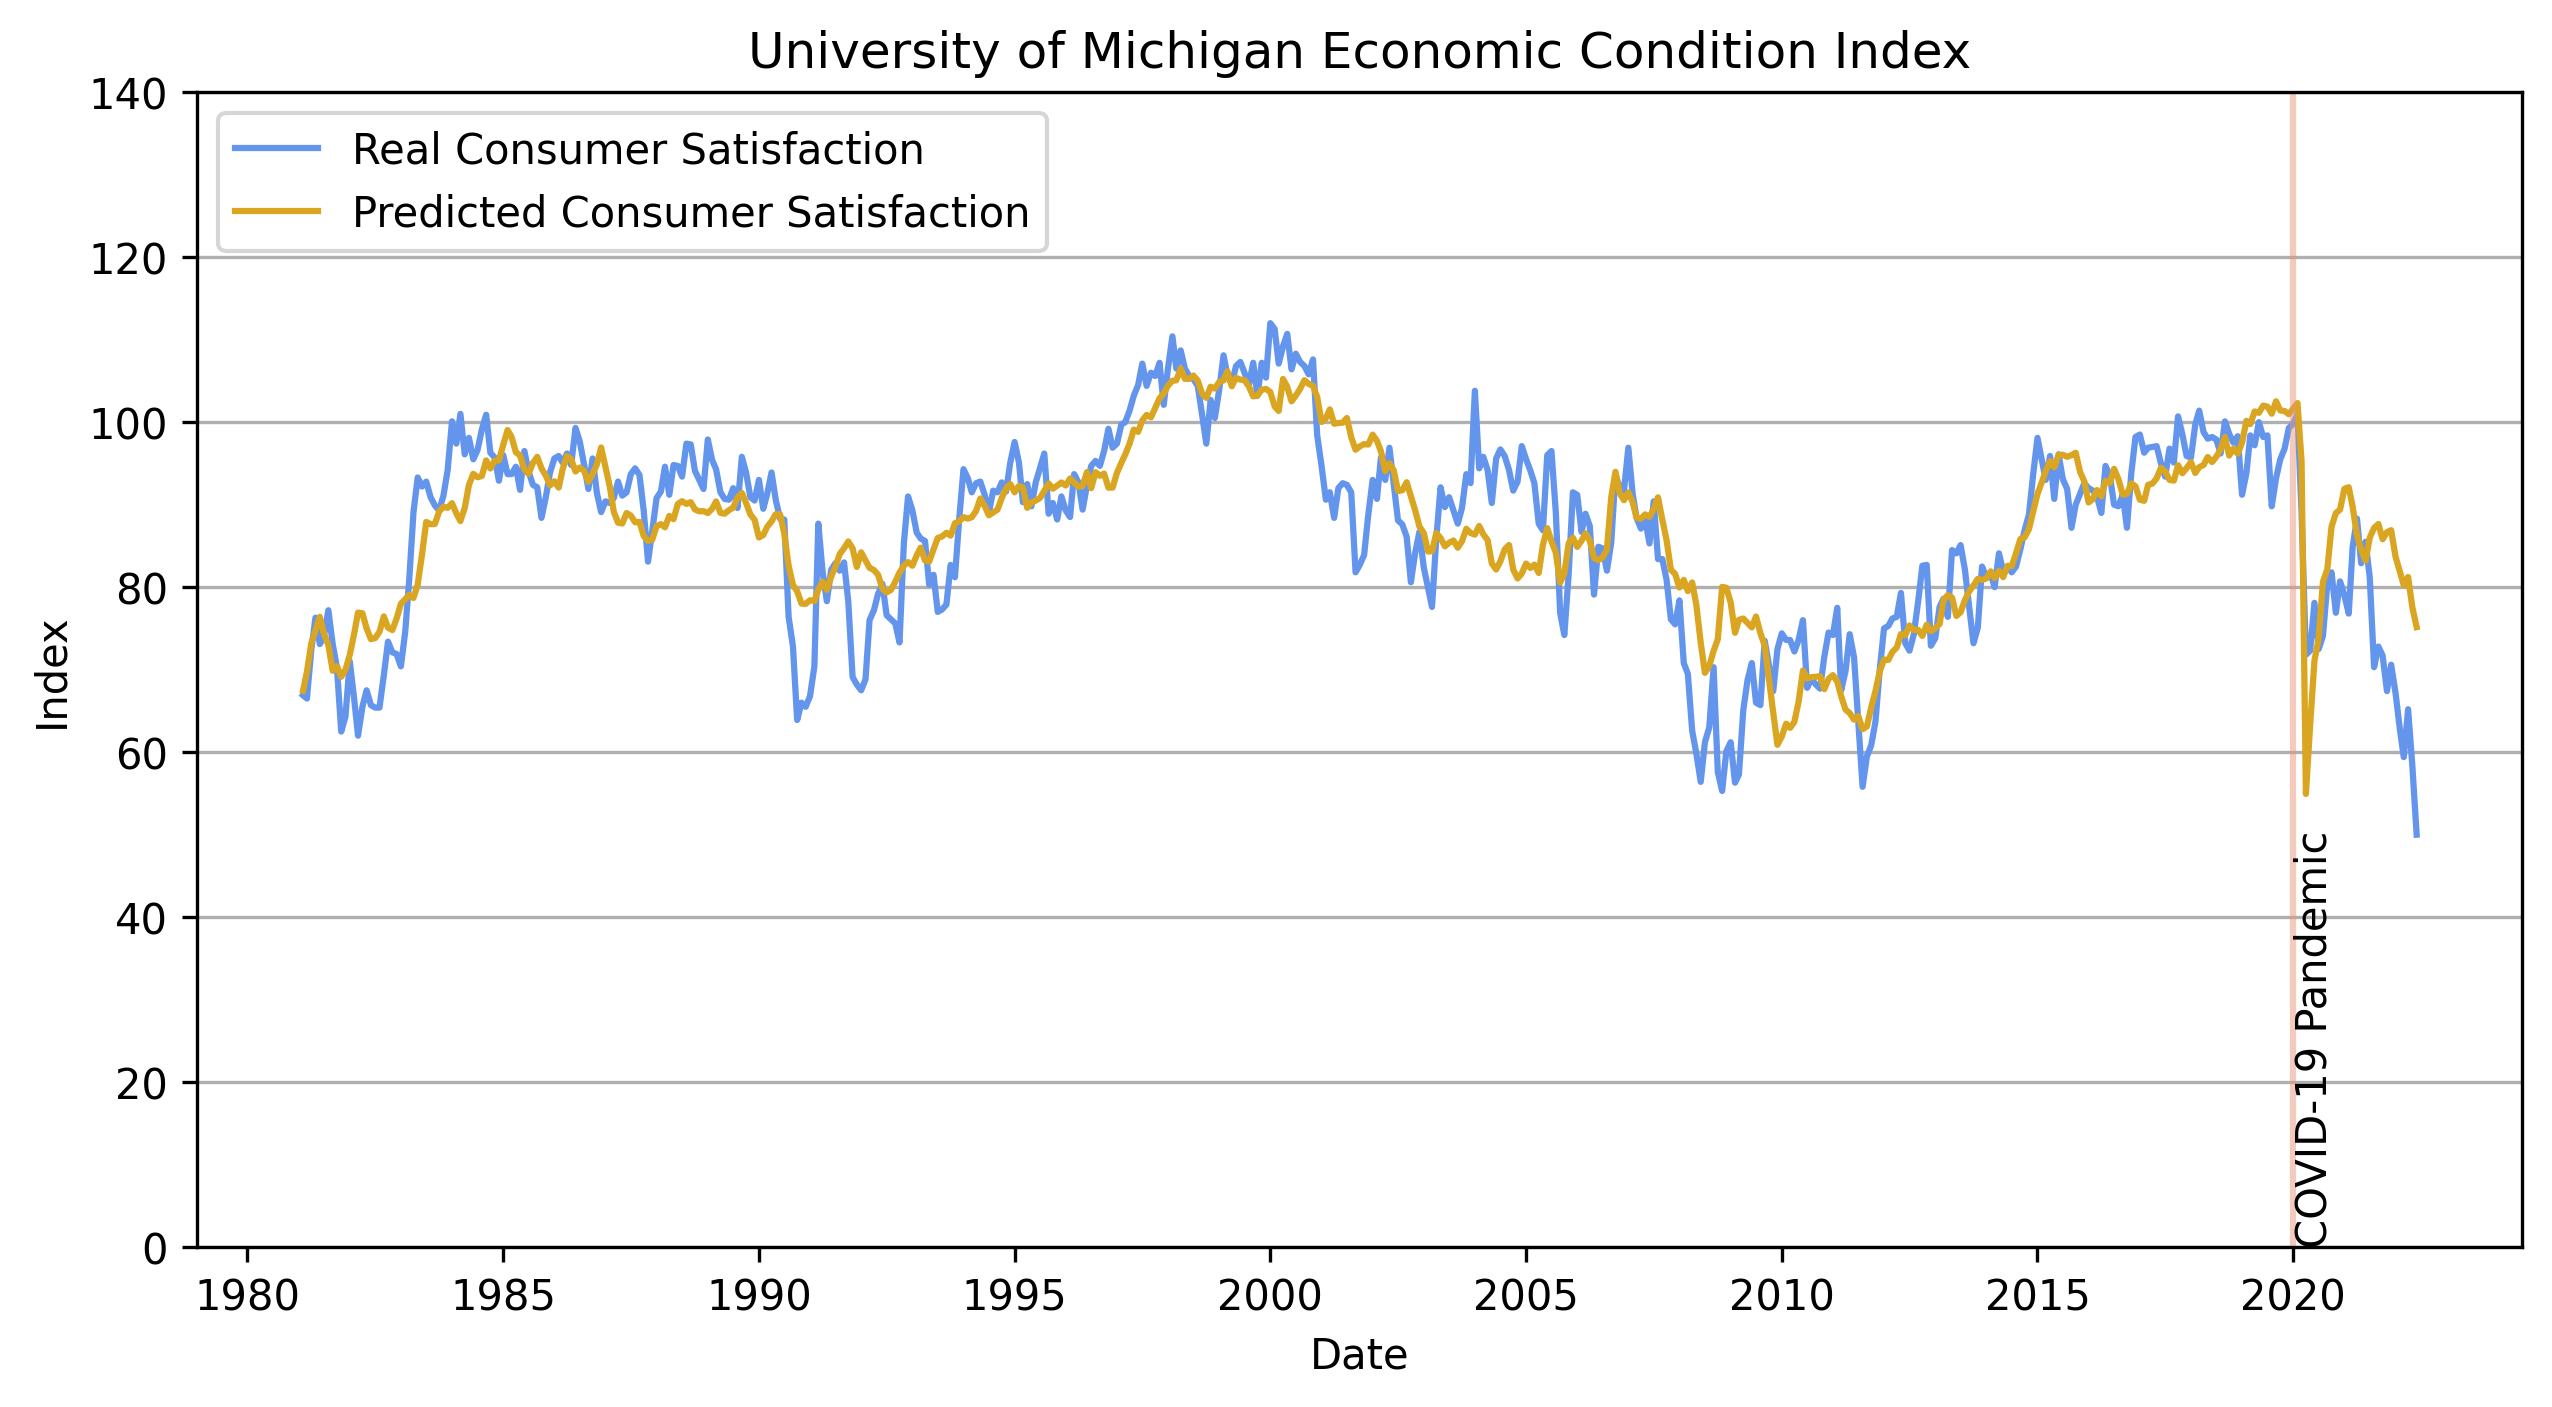

In [24]:
fig, ax = plt.subplots()

fig.set_dpi(300)
fig.set_size_inches(10, 5)

ax.set_ylim((0, 140))
ax.grid(axis='y')
ax.set_title('University of Michigan Economic Condition Index')
ax.set_xlabel('Date')
ax.set_ylabel('Index')
#fig.title('Consumer Satisfaction')

true_plot, = ax.plot(timeline.to_timestamp(), Y, color='cornflowerblue')
pred_plot, = ax.plot(timeline.to_timestamp(), reg.predict(features), color='goldenrod')

ax.axvline(x=pd.to_datetime('2020-01'), color='darksalmon', alpha=0.5)
ax.text(s='COVID-19 Pandemic', x=pd.to_datetime('2020-01'), y=0, verticalalignment='bottom', rotation='vertical')
ax.legend([true_plot, pred_plot], ['Real Consumer Satisfaction', 'Predicted Consumer Satisfaction'])


We indeed see that overall our model does a relatively good job of predicting the sentiment prior to pandemic. Now, we will restrict the training dataset for the model.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(pre_pandemic_X, pre_pandemic_Y, test_size=0.5, random_state=1)

reg2 = LinearRegression()
reg2.fit(X_train, y_train)

LinearRegression()

In [26]:
new_pred_plot, = ax.plot(timeline.to_timestamp(), reg2.predict(features), color='plum')

ax.legend([new_pred_plot], ['Predicted Consumer Satisfaction Trained on 50%'])


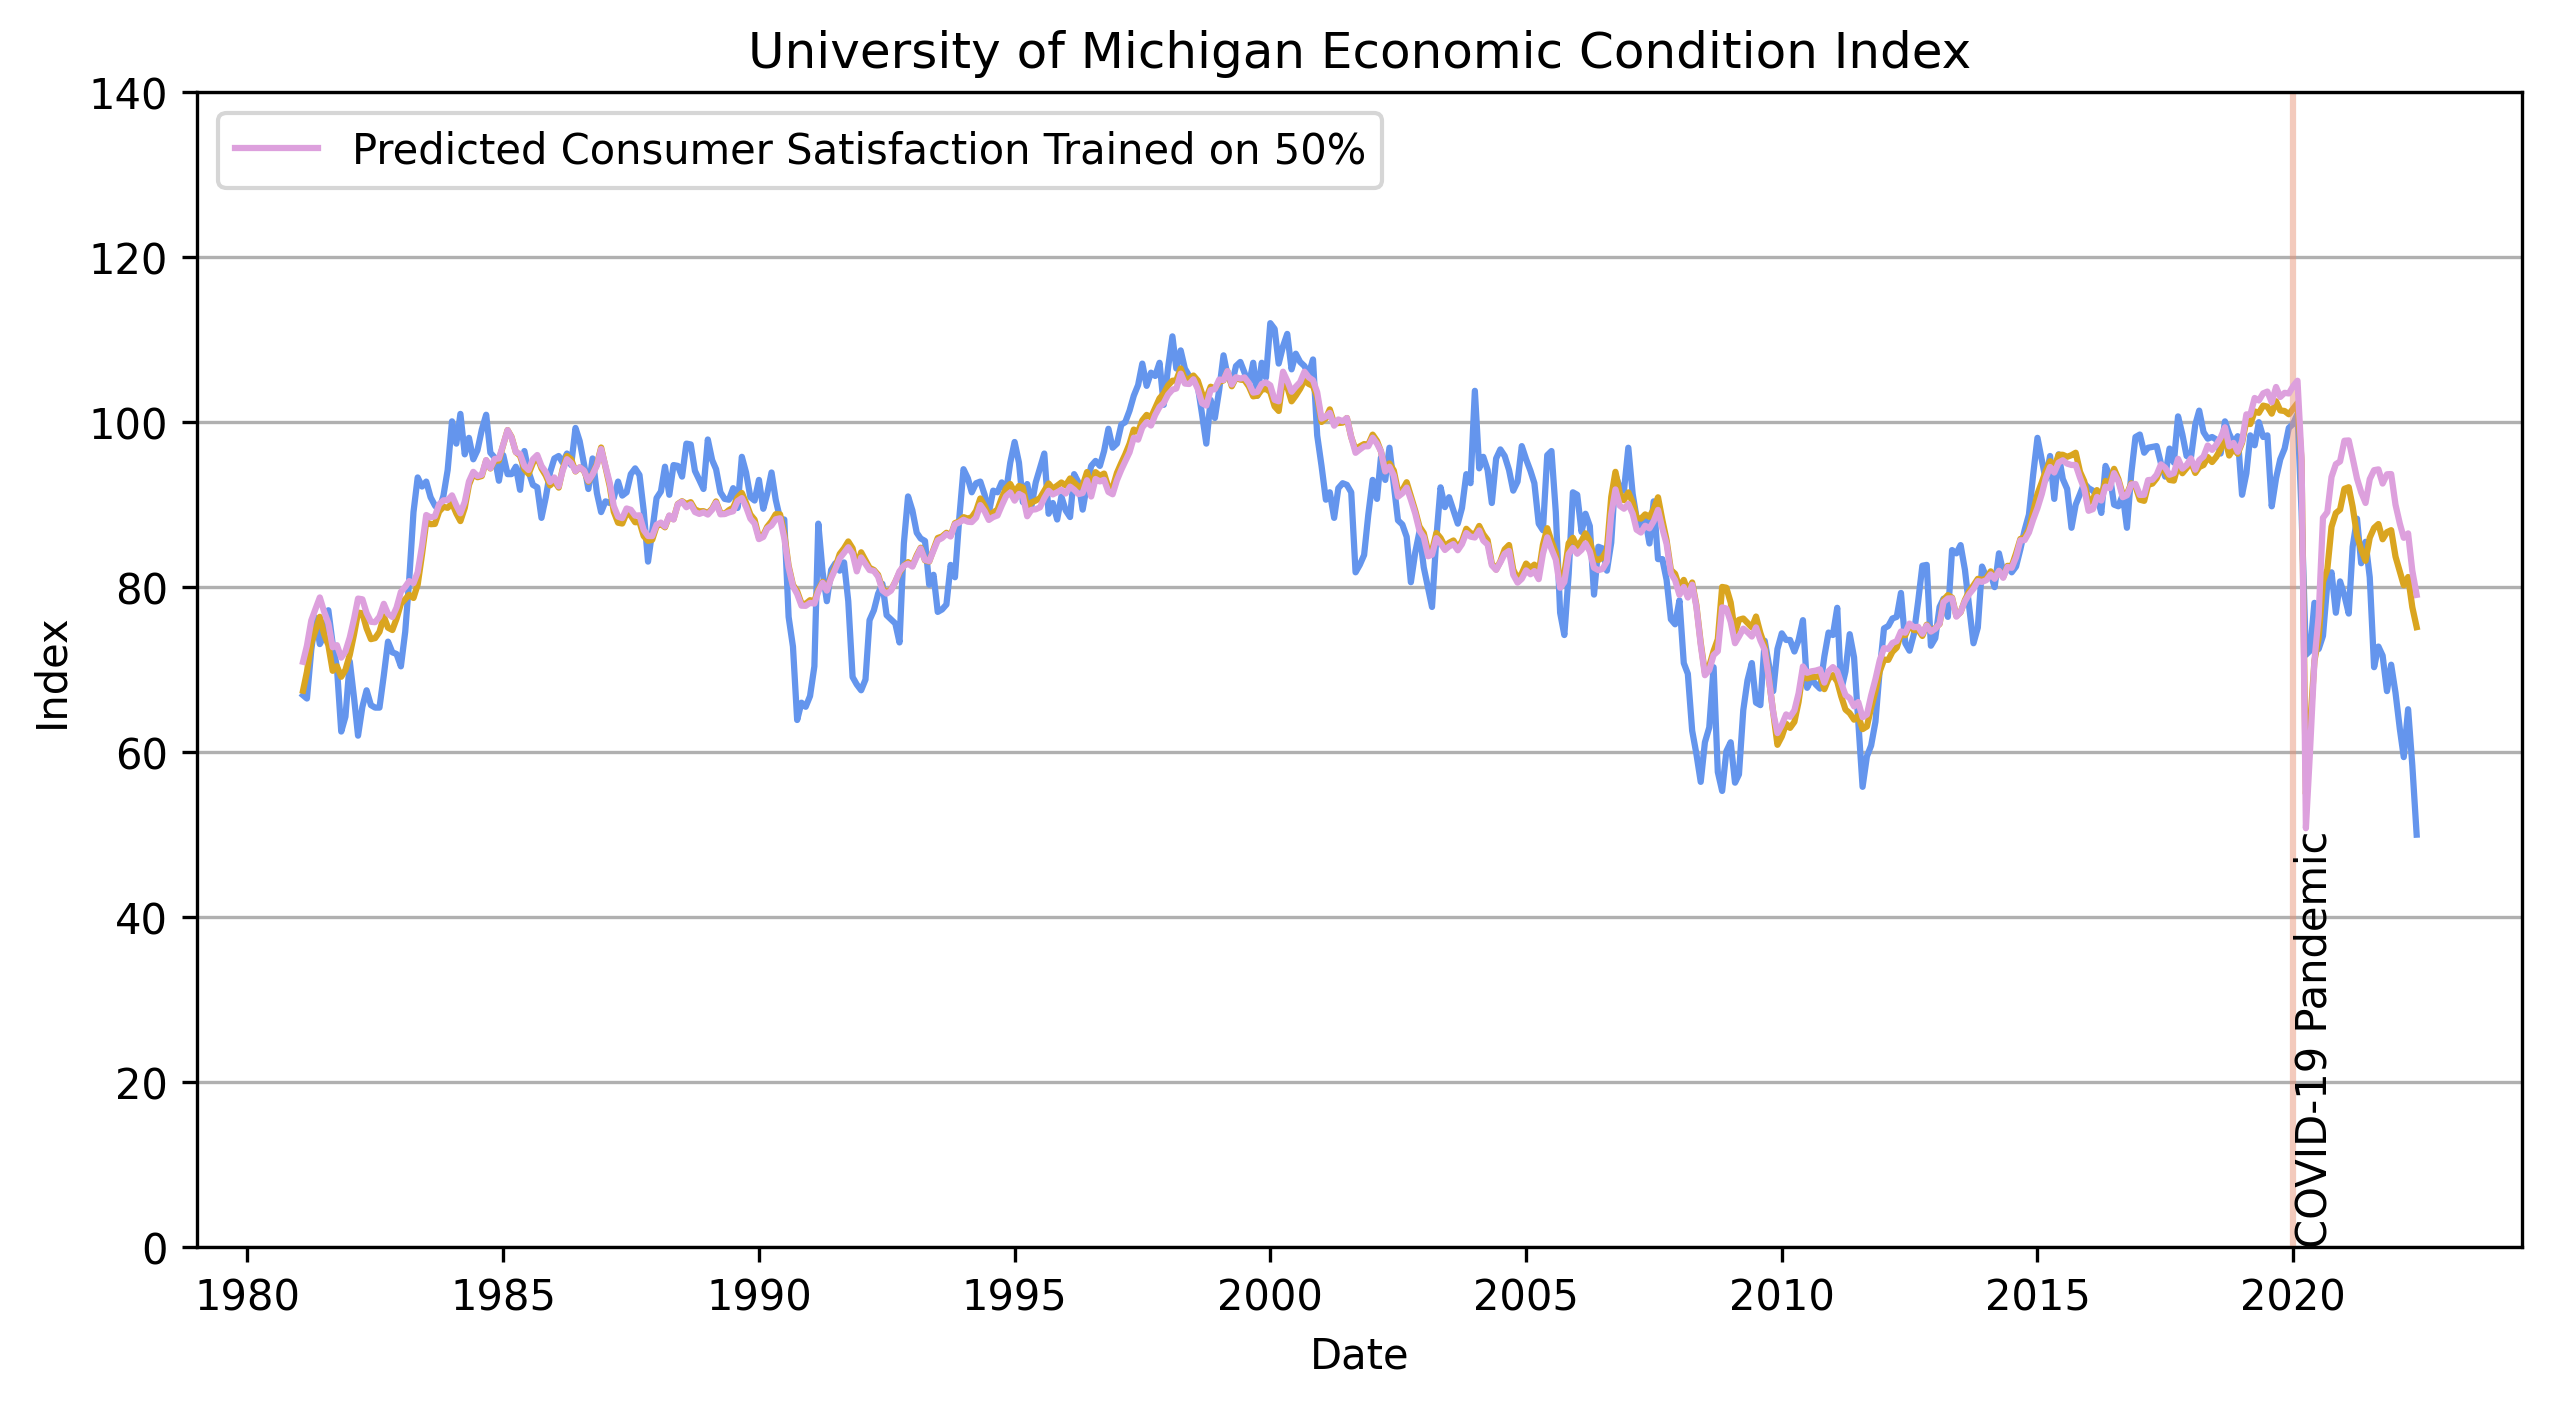

In [27]:
fig

We see that even restricting the training data to 50% of pre-pandemic data generates a similar prediction. This is of course to be expected from a low-variance model like linear regression.